# Quantum Superposition vs. Mixture: a module rephrased from the IBM classroom module "Quantum Coin" - also serve as quick intro to Qiskit
### For class 2025 spring "Introduction to quantum information and quantum computing" Seoul National University, Department of Physics and Astronomy Instructor: Dohun Kim 

### For maximizing students' Qiskit programming capability, we intentionally try to use the real backend even though sometimes running on a simulator is simpler. 

## Classical mixture

Let's start with a statistical mixture of spin up and spin down (with respect to an externally applied magnetic field - say z-direction) as an example of *classical probabilistic state*, where the outcome is essentially random. Using a IBM QC backend, we randomly prepare 0 or 1 as initial state and measure in z-basis (some terminologies may not be discussed at this stage of the class, but it's okay. We will learn them later.  
$$|\uparrow\rangle \sim |0\rangle$$
$$|\downarrow \rangle \sim |1\rangle$$

### Step 1: Create quantum circuit

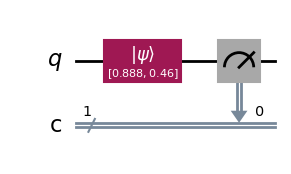

In [39]:
# Loading necessary packages
import math, random
from qiskit.circuit import QuantumRegister, ClassicalRegister, QuantumCircuit, Parameter

# Define registers
qr = QuantumRegister(1, 'q')  # QuantumRegister(Size or no. of qubits in the circuit, 'q': Name of the qubit)  
cr = ClassicalRegister(1, 'c') # Classical register for storing measurement result
qc = QuantumCircuit(qr, cr) # Generate a quantum circuit with specified quantum and classical bits 

# Initialize the quantum state
a = random.random()
b = math.sqrt(1.0-a**2)

# Initialize qubit with specified probability amplitues a and b (a for basis state 0 and b for 1; here they are randomized such that their sum is 1)
qc.initialize([a, b]) # 0th qubit = a|0> + b|1>

# measure(0, 0) means measure the first qubit (we count from 0) and store the result in the first classical bit. Here measurement is done along z-direction (usually called computational basis)
qc.measure(0, 0) # measure 0th qubit and record to 0th cbit

# Function to draw circuit - mp1 returns a matplotlib figure object
qc.draw('mpl')

### Step 2: Optimize problem for quantum execution

To run our experiment on a real quantum computer, we need to load Qiskit Runtime Service, and select a quantum computer (or a "backend"). Below, we simply select the least busy quantum computer available provided by IBM to us.

In [47]:
# Load the Qiskit Runtime service
from qiskit_ibm_runtime import QiskitRuntimeService # Loading necessary packages
token = ""
service = QiskitRuntimeService(channel="ibm_quantum", token=token)

# Use the least busy backend
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits = 1)
print(backend.name)

ibm_sherbrooke


We now must transpile the circuit, meaning we must map our circuit onto the base gates available to our chosen quantum computer, and we want to optimize our circuit for running on that quantum computer. 

This optimization process goes through a few rewriting steps to reduce the effects caused by noise on the outcomes. For more details on this process, visit https://docs.quantum.ibm.com/api/qiskit/transpiler.

In [48]:
# Transpile the circuit and optimize for running on the quantum computer selected
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(optimization_level = 3, backend = backend) # Higher optimization_level generates more optimized circuits; 3 is the heaviest level of optimization, but takes the longest transpilation time. 
qc_ibm = pm.run(qc)

### Step 3: Execute using Qiskit Runtime Primitives

Now we want to run this on a real quantum computer. All the necessary syntax for that is in the code block below.

In [35]:
# This runs on the real quantum computer
# Specify that we want to use only a single shot, to represent a single measurement of a spin in a SG device.
num_shots = 1

# Load the Runtime primitive and session
from qiskit_ibm_runtime import Options, Session, SamplerV2 as Sampler

# Evaluate the problem using a QPU via Qiskit IBM Runtime
with Session(backend) as session:
    sampler = Sampler(mode = session)
    dist = sampler.run([qc_ibm], shots = num_shots).result()
session.close()
counts=dist[0].data.c.get_counts()

If you have exhausted your allotted time on real quantum computers, or if you are without an internet connection, you can use the next code block, which will run the code on a local simulator. 

**The code block above is for running on a real QPU, and the code block below simulates in your local computer, mimicing the quantum system above. Both code blocks should return similar results.**

In [49]:
# This uses a local simulator for real backend
from qiskit_aer import AerSimulator

# This generates a simulator that mimics the real quantum system
backend_sim = AerSimulator.from_backend(backend)

# Import a sampler primitive from qiskit manually 
from qiskit.primitives import BackendSamplerV2
sampler = BackendSamplerV2(backend = backend_sim)
num_shots = 10000

# This runs the job
dist = sampler.run([qc_ibm], shots = num_shots).result()[0]

# This selects measurement counts for the 0th circuit, which in this case is the only circuit
counts_raw = dist.data.c.get_counts()

from qiskit.result import QuasiDistribution
counts = QuasiDistribution({outcome: freq / num_shots for outcome, freq in counts_raw.items()})

### Step 4: Post-processing and classical analysis

For this very simple experiment, classical analysis just consists of visualizing the experimental outcome.

counts =  {0: 0.7888, 1: 0.2112}


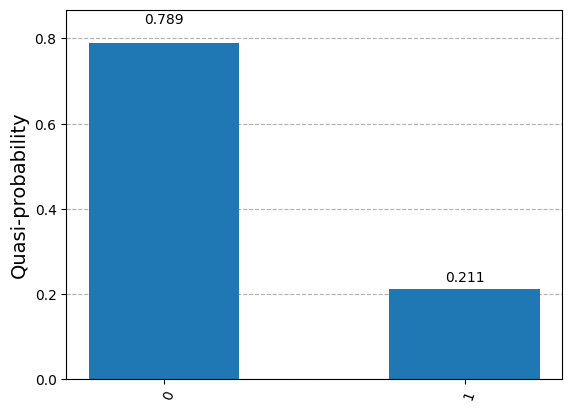

In [50]:
print("counts = ", counts)

from qiskit.visualization import plot_histogram
plot_histogram(counts)

From this example, it is evident that if we repeat the steps, we will get probability 0.5 for state 0 and 0.5 for state 1. 


## Quantum coin

We can create a similar probabilistic state using a qubit on our quantum computer. Like the coin flip, a qubit also can be measured in two possible states: $|0\rangle$ and $|1\rangle$. We create the probabilistic, "superposition" state by starting in the state $|0\rangle$, and then applying something called a Hadamard gate to the qubit. This puts it in an equal superposition of $|0\rangle$ and $|1\rangle$. Note that while this superposition state may look and behave like the coin at first blush, we will soon see that there is much more to it than that. The point of this module is to show you that a superposition is not the same as a classical coin flip.

So, since the qubit is in an equal superposition of 0 and 1, when we measure the qubit, there will be a 50% chance we measure $|0\rangle$, 50% chance we measure $|1\rangle$. We write this state a little differently from the classical probabilistic case, for reasons that will become clear later:

$|\psi\rangle = \frac{1}{\sqrt{2}} |0\rangle + \frac{1}{\sqrt{2}} |1\rangle$

Here, the probabilities of measuring each of the two states are **no longer** equal to the coefficients, as was the case in the classical probabilistic state above. Instead, it is the **square** of the coefficients that gives us the probabilities, and each of these coefficients can now be complex, meaning they can have both real and imaginary parts. 

Despite these differences, though, the outcome of measuring this state is essentially the same as flipping a coin. 



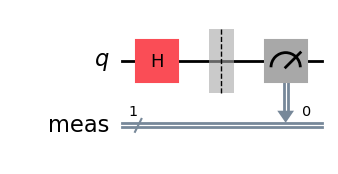

In [54]:
qcoin = QuantumCircuit(1)
qcoin.h(0)
qcoin.measure_all()

qcoin.draw('mpl')

In [67]:
# Use the least busy backend
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=1)
print(backend.name)

#Transpile the circuit and optimize for running on the quantum computer selected
pm = generate_preset_pass_manager(optimization_level = 3, backend = backend)
qc_ibm = pm.run(qcoin)

ibm_sherbrooke
('init', 'layout', 'routing', 'translation', 'optimization', 'scheduling')


So, in effect, applying the Hadamard gate is the analogue to flipping a coin. And just like flipping a 100 times to look at the statistics of the coin landing heads up or down, we can do something similar on Qiskit with our “quantum coin." We can use a Qiskit primitive called `Sampler` which will repeat a circuit several times to sample the statistics of the resulting state. With 100 samples of the circuit above, we have something that looks basically identical to the classical coin histogram, up to some statistical fluctuation.

In [ ]:
# Specify that we want to use only a single shot, to represent a single measurement of a spin in a SG device.
num_shots = 100

# Evaluate the problem using a QPU via Qiskit IBM Runtime
with Session(backend) as session:
    sampler = Sampler(mode = session)
    dist = sampler.run([qc_ibm], shots = num_shots).result()
session.close()
counts=dist[0].data.meas.get_counts()

Again, for a local simulator, run the code in the next block.

counts =  {0: 0.52, 1: 0.48}


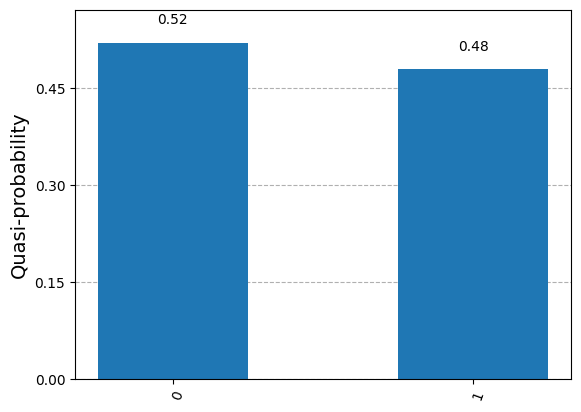

In [ ]:
# Use Aer backend simulator
backend_sim = AerSimulator.from_backend(backend)
sampler = BackendSamplerV2(backend = backend_sim)

# This runs the job
dist = sampler.run([qc_ibm], shots = num_shots).result()[0]

# This selects measurement counts for the 0th circuit, which in this case is the only circuit
counts_raw = dist.data.meas.get_counts()
counts = QuasiDistribution({outcome: freq / num_shots for outcome, freq in counts_raw.items()})

print("counts = ", counts)
plot_histogram(counts)

## The quantum revealed: an experiment in three dimensions

So far we have only considered measuring spin in z-direction. The difference between quantum superposition and a classical mixture is revealed when we do measurement in other directions; we shall conduct measurement in the x-direction in the following section.

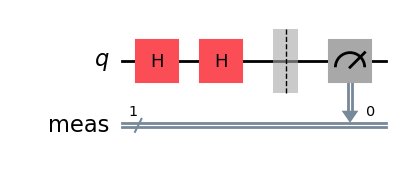

In [65]:
qcoin = QuantumCircuit(1)
qcoin.h(0)
qcoin.h(0)
qcoin.measure_all()

qcoin.draw('mpl')

In [ ]:
# Use the least busy backend
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=1)
print(backend.name)

#Transpile the circuit and optimize for running on the quantum computer selected
pm = generate_preset_pass_manager(optimization_level = 3, backend = backend)
qc_ibm = pm.run(qcoin)

ibm_sherbrooke


In [69]:
# Specify that we want to use 100 shots, to represent 100 measurements of a spin in a SG device.
num_shots = 100

# Evaluate the problem using a QPU via Qiskit IBM Runtime
with Session(backend) as session:
    sampler = Sampler(mode = session)
    dist = sampler.run([qc_ibm], shots = num_shots).result()
session.close()
counts=dist[0].data.meas.get_counts()

counts =  {0: 1.0}


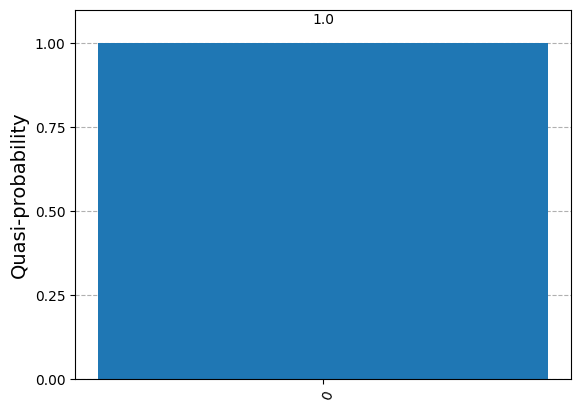

In [66]:
# Use Aer backend simulator
backend_sim = AerSimulator.from_backend(backend)
sampler = BackendSamplerV2(backend = backend_sim)

# This runs the job
dist = sampler.run([qc_ibm], shots = num_shots).result()[0]

# This selects measurement counts for the 0th circuit, which in this case is the only circuit
counts_raw = dist.data.meas.get_counts()
counts = QuasiDistribution({outcome: freq / num_shots for outcome, freq in counts_raw.items()})

print("counts = ", counts)
plot_histogram(counts)

Point 1: We may interprete the circuit as the following. We first prepare superposition state and ask whether it is parallel (0) or antiparallel (1) to x direction.  
Point 2: The result here is not random. We are sure that the state is in parallel to x direction.

#### Discussions:
<details>
<summary>
What happens when we do x measurement on statistical mixture given above ?

<details>
<summary>
What would be the result when we perform repeated y-direction measurement on the superposition state given above ?

<details>
<summary>
In the class, I explained that the quantum superposition state has coherence : system's capability to exhibit interference. And indeed this coherence made it possible to distinguish superposition state from statistical mixture. Where is interference in this example ?

<details>
<summary>
In fact, the collection of measurement results in all directions constitutes quantum state tomography (mostl simply in this case, a single qubit state tomography). We will learn more about state tomography in later chapters. 
    